## omibio Analysis demo
This is an example of using omibio for process analysis. We used omibio to analyze a sequence of the *E. coli* genome. The main contents include:
- Read fasta files.
- Predict Open Reading Frames (ORFs).
- Write the prediction ORF as a FASTA file.
- Perform sliding window GC content calculation.
- Perform motif searches.
- Visualize ORFs, sliding window GC, and motifs.



>EColiORF_1
ATGGACTCCACGCTCATCTCCACTCGTCCCGATGAAGGGACGCTTTCGTTAAGTCGCGCCCGACGAGCTGCGTTAGGCAG
CTTCGCTGGTGCCGTCGTCGACTGGTATGATTTTTTACTCTATGGCATCACCGCCGCACTGGTGTTTAATCGCGAGTTTT
TCCCGCAAGTAAGCCCGGCGATGGGAACGCTCGCCGCATTTGCTACCTTTGGCGTCGGATTTCTTTTCCGTCCGCTCGGC
GGTGTCATTTTCGGTCACTTTGGCGACCGACTGGGACGTAAGCGCATGTTAATGCTGACCGTCTGGATGATGGGCATCGC
GACAGCCTTGATTGGTATTCTTCCTTCATTCTCGACCATTGGGTGGTGGGCACCTATTTTGCTGGTGACACTGCGTGCCA
TTCAGGGATTTGCAGTCGGCGGCGAATGGGGAGGCGCGGCGTTGCTTTCCGTTGAAAGTGCACCGAAAAATAAAAAAGCC
TTTTACAGTAGCGGTGTACAAGTTGGCTACGGTGTAGGTTTACTGCTTTCAACCGGACTGGTTTCATTGATCAGTATGAT
GACGACTGACGAACAGTTTTTAAGCTGGGGCTGGCGCATTCCTTTCCTGTTTAGCATCGTACTGGTACTGGGAGCATTGT
GGGTGCGCAATGGCATGGAGGAGTCCGCGGAATTTGAACAACAGCAACATTATCAAGCTGCCGCGAAAAAACGCATCCCG
GTTATCGAAGCGCTGTTACGACATCCCGGTGCTTTCCTGAAGATTATTGCGCTACGACTGTGCGAATTGCTGACGATGTA
CATCGTTACTGCCTTTGCACTTAATTATTCAACCCAGAATATGGGGCTACCGCGCGAACTTTTCCTTAATATTGGTTTGC
TGGTAGGTGGATTAAGCTGCCTGACAATTCCCTGTTTTGCCTGGCTTGCCGATCGTTTTGGTCGCCGTAGGGTTTATATC
ACAGGTACGTTAATCG

<Axes: title={'center': 'Motif Distribution'}, xlabel='Sequence Position', ylabel='Strand'>

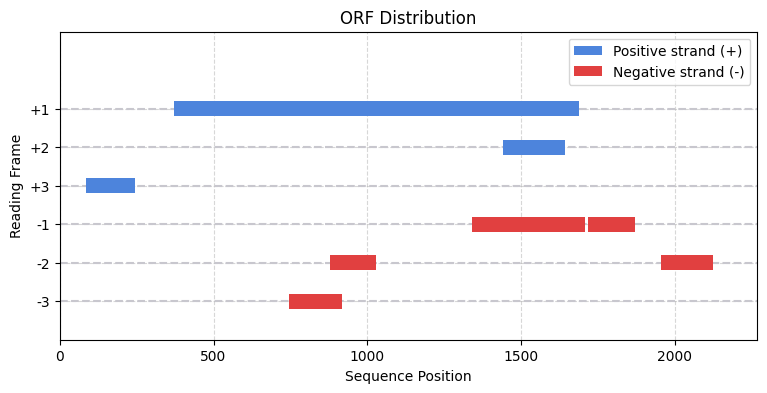

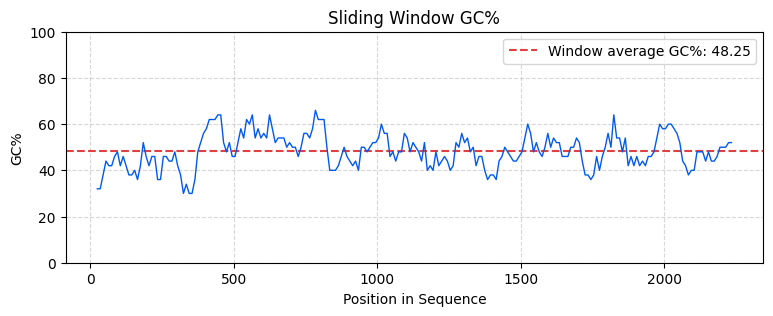

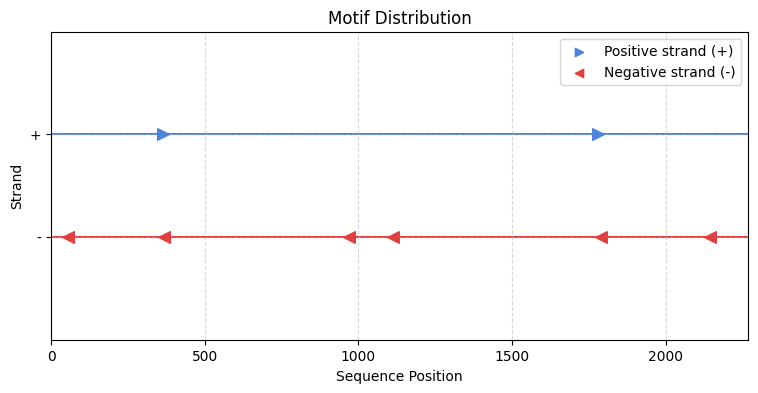

In [5]:
from pathlib import Path
from omibio import *  # for type annotations
from omibio.io import read_fasta, write_fasta
from omibio.analysis import find_orfs, sliding_gc, find_motifs
import re

nb_dir = Path().resolve()

input_fasta_path = nb_dir.parent / "data" / "e_coli_gene_sequence.fasta"
output_fasta_path = nb_dir.parent / "output" / "demo_output.fasta"


# Get sequence id & sequence
seqs: SeqCollections = read_fasta(input_fasta_path)
seq_entry: SeqEntry = seqs.entry_list()[0]
sequence: Sequence = seq_entry.seq

# Find ORFs
orf_result: IntervalResult = find_orfs(sequence, min_length=150, include_reverse=True)

# Sliding GC content calculation
gc_result: IntervalResult = sliding_gc(sequence, window=50, step=10)

# Motifs
pattern = re.compile(r'(AGGAGG|AGGAG|GGAGG|AGGA|GAGG|GGAG).{5,12}ATG')
motif_result: IntervalResult = find_motifs(sequence, pattern, include_reverse=True)

# Visualization & output results
orf_dict: dict = {}
for i, seq_interval in enumerate(orf_result, start=1):
    orf_dict[f"EColiORF_{i}"] = seq_interval

lines = write_fasta(file_name=output_fasta_path, seqs=orf_dict, line_len=80)
print("\n".join(lines[:25]) + "\n...")

orf_result.plot()
gc_result.plot()
motif_result.plot()





## Conclusion
In this analysis, we read a DNA sequence from E. coli and performed three types of analysis: ORF lookup, sliding GC calculation, and motif lookup.

- First, we conduct a preliminary analysis of the sequence.
    - For ORF lookup, we set the minimum ORF length to 150bp `(min_length=150)` to filter out shorter “false positive” ORFs; we also look for the reverse complementary sequence of the sequence `(include_reverse=True)` to obtain the maximum probability.
    - For the calculation of sliding GC, we set the window length to a small 50bp and the step size to 10bp `(window=50, step=10)`. The reason for this is that the overall DNA sequence GC fluctuations in eukaryotes are relatively insignificant, and a smaller window length can more sensitively capture small GC peaks.
    - For motif searching, we used regular expression searching and compiled the following pattern: `re.compile(r'(AGGAGG|AGGAG|GGAGG|AGGA|GAGG|GGAG).{5,12}ATG')`. In this regular expression, the last `'ATG'` is the start codon of the encoded sequence, while the preceding A and G sequences are several common ribosome binding site (RBS) sequences. They typically appear upstream of the start codon.`'{5,12}'` then defines the distance between these two sequences. Similarly, we also search for motif in reverse complementary sequences`(include_reverse=True)`.

- Then, we output and visualize the results.
    - We can use the `write_fasta()` function to write ORF results into a fasta file.
    - we can perform simple visualization of the analysis results by using the `.plot()` method of `IntervalResult` (returns of `find_orfs()`, `sliding_gc()`, `find_motifs()`).

- Finally, we analyzed and compared the results.
    - From the first ORF distribution chart, we found a relatively long ORF in the +1 frame of the positive chain.
    - From the second sliding GC chart, we found that the sequence has several GC peaks, which are located roughly within the long ORF we previously found.
    - In the third motif distribution chart, we found a motif matching the pattern before the previously determined start position of the long ORF. This is very strong evidence.

Based on the above analysis, we can roughly determine that this DNA sequence contains a gene. We can conduct further analysis, such as determining the specific location of the gene based on the `start` and `end` attributes of the `SeqInterval` class stored in `IntervalResult` from `find_orfs`. We won't go into details here.
In fact, the gene we found in this analysis is the gene encoding the shikimate transport protein (shiA) that actually exists in E. coli. Hopefully, this use case will give you an understanding of the features and some usage methods of omibio.
